## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transform the Data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Load the Data

In [ ]:
# Load CIFAR 10 dataset with training and testing Components
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48765303.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualize a few images

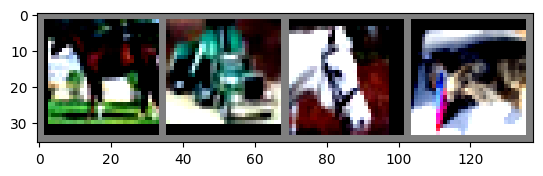

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


batch_size = 4

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

## Define ResNet Architecture

We have modified the architecture to reduce blocks in layers. The following modifications were made to ResNet 18 architecture found at https://github.com/kuangliu/pytorch-cifar. 

- Reducing blocks from 2 to 1 in layer 2,3,4 
- Dropout of 0.4 added 
- Adadelta Optimizer 

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,1,1,1])

In [ ]:
net = ResNet18()

In [ ]:
## Move model to CUDA
net = net.to(device)

## Model Summary and Parameters
eters
We are checking total number of trainable params and visualizing the model summary

In [ ]:
summary(net, input_size = (3,32,32), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
total_trainable_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
print("Total Trainable Parameters: %d"%total_trainable_parameters)

Total Trainable Parameters: 4977226


Which is under 5 million :)

## Define Train and Test functions 

In [ ]:
# Training
def train(epoch):
    
    ## Setting the model in training mode
    net.train()
    
    ## Initialize Epoch loss and accuracy 
    train_loss = 0
    train_acc = 0 
    
    ## Number of correct examples
    correct = 0
    total = 0


    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ## Movie inputs and targets to cuda
        inputs, targets = inputs.to(device), targets.to(device)

        ## Set gradients to zero after every batch
        optimizer.zero_grad()

        ## Get predictions
        outputs = net(inputs)

        ## Compute Loss
        loss = criterion(outputs, targets)

        ## Do backprop
        loss.backward()

        ## Update weights 
        optimizer.step()

        ## Add loss
        train_loss += loss.item()
        
        ## Computer Number of correct examples
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
    
    
    train_acc += 100.*correct/total


   
    
    return train_loss / len(trainloader) , train_acc

In [ ]:
def test(epoch):
    ## Setting models to evaluation mode
    net.eval()
    
    ## Initialize epoch loss and accuracy
    test_loss = 0
    test_acc = 0 

    ## Number of correct examples
    correct = 0
    total = 0


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            ## Move inputs and targets to cuda

            inputs, targets = inputs.to(device), targets.to(device)

            ## Get predictions

            outputs = net(inputs)

            ## Compute Loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            ## Computer Accuracy 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    test_acc = 100.*correct/total
    
    return test_loss / len(testloader) , test_acc

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Defining Loss function, optimizer and LR Scheduler

In [ ]:
LEARNING_RATE = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters(), lr = LEARNING_RATE,
                       weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = criterion.to(device)

## Train the model


In [ ]:
EPOCHS = 100
best_testing_accuracy = 0 

## Define model history to store accuracy and losses

history = {}
history["accuracy"] = []
history["test_accuracy"] = []
history["loss"] = []
history["test_loss"] = []

In [ ]:
## First train for 100 

for epoch in tqdm(range(EPOCHS)):
  
  start_time = time.time()

  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)

  scheduler.step()

  history["accuracy"].append(train_acc)
  history["test_accuracy"].append(test_acc)
  history["loss"].append(train_loss)
  history["test_loss"].append(test_loss)


  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_acc > best_testing_accuracy:
    best_testing_accuracy = test_acc
    torch.save(net.state_dict(), 'model.pt')

  
  print('Training Loss: %.3f | Training Acc: %.3f%% | Testing Loss: %.3f | Testing Acc:%.3f%%'
                  % (train_loss, train_acc, test_loss, test_acc))

  1%|          | 1/100 [00:37<1:01:18, 37.16s/it]

Training Loss: 1.449 | Training Acc: 46.886% | Testing Loss: 1.385 | Testing Acc:51.500%


  2%|▏         | 2/100 [01:14<1:01:11, 37.46s/it]

Training Loss: 1.012 | Training Acc: 63.834% | Testing Loss: 0.972 | Testing Acc:64.830%


  3%|▎         | 3/100 [01:54<1:02:07, 38.43s/it]

Training Loss: 0.829 | Training Acc: 70.726% | Testing Loss: 0.901 | Testing Acc:70.030%


  4%|▍         | 4/100 [02:32<1:01:03, 38.16s/it]

Training Loss: 0.708 | Training Acc: 75.252% | Testing Loss: 0.935 | Testing Acc:68.630%


  5%|▌         | 5/100 [03:09<1:00:12, 38.02s/it]

Training Loss: 0.629 | Training Acc: 78.328% | Testing Loss: 0.831 | Testing Acc:73.850%


  6%|▌         | 6/100 [03:46<59:03, 37.70s/it]  

Training Loss: 0.573 | Training Acc: 80.050% | Testing Loss: 0.663 | Testing Acc:77.260%


  7%|▋         | 7/100 [04:24<58:12, 37.56s/it]

Training Loss: 0.520 | Training Acc: 82.070% | Testing Loss: 0.742 | Testing Acc:76.210%


  8%|▊         | 8/100 [05:02<57:42, 37.63s/it]

Training Loss: 0.484 | Training Acc: 83.382% | Testing Loss: 0.783 | Testing Acc:75.590%


  9%|▉         | 9/100 [05:39<56:57, 37.55s/it]

Training Loss: 0.448 | Training Acc: 84.576% | Testing Loss: 0.710 | Testing Acc:76.900%


 10%|█         | 10/100 [06:16<56:14, 37.49s/it]

Training Loss: 0.423 | Training Acc: 85.420% | Testing Loss: 0.642 | Testing Acc:79.000%


 11%|█         | 11/100 [06:54<55:48, 37.62s/it]

Training Loss: 0.400 | Training Acc: 86.078% | Testing Loss: 0.580 | Testing Acc:80.730%


 12%|█▏        | 12/100 [07:32<55:20, 37.74s/it]

Training Loss: 0.376 | Training Acc: 87.054% | Testing Loss: 0.783 | Testing Acc:76.460%


 13%|█▎        | 13/100 [08:10<54:41, 37.72s/it]

Training Loss: 0.353 | Training Acc: 87.766% | Testing Loss: 0.846 | Testing Acc:76.320%


 14%|█▍        | 14/100 [08:47<53:55, 37.62s/it]

Training Loss: 0.336 | Training Acc: 88.306% | Testing Loss: 0.546 | Testing Acc:83.190%


 15%|█▌        | 15/100 [09:24<53:03, 37.46s/it]

Training Loss: 0.323 | Training Acc: 88.956% | Testing Loss: 0.575 | Testing Acc:81.920%


 16%|█▌        | 16/100 [10:02<52:40, 37.63s/it]

Training Loss: 0.306 | Training Acc: 89.468% | Testing Loss: 0.473 | Testing Acc:85.710%


 17%|█▋        | 17/100 [10:40<51:56, 37.55s/it]

Training Loss: 0.289 | Training Acc: 90.032% | Testing Loss: 0.497 | Testing Acc:84.520%


 18%|█▊        | 18/100 [11:18<51:44, 37.86s/it]

Training Loss: 0.281 | Training Acc: 90.282% | Testing Loss: 0.436 | Testing Acc:86.230%


 19%|█▉        | 19/100 [11:56<51:10, 37.91s/it]

Training Loss: 0.263 | Training Acc: 91.004% | Testing Loss: 0.546 | Testing Acc:83.830%


 20%|██        | 20/100 [12:34<50:19, 37.75s/it]

Training Loss: 0.254 | Training Acc: 91.258% | Testing Loss: 0.424 | Testing Acc:87.000%


 21%|██        | 21/100 [13:11<49:39, 37.71s/it]

Training Loss: 0.245 | Training Acc: 91.382% | Testing Loss: 0.470 | Testing Acc:85.680%


 22%|██▏       | 22/100 [13:49<48:51, 37.58s/it]

Training Loss: 0.232 | Training Acc: 91.904% | Testing Loss: 0.626 | Testing Acc:82.340%


 23%|██▎       | 23/100 [14:26<48:13, 37.58s/it]

Training Loss: 0.227 | Training Acc: 92.234% | Testing Loss: 0.476 | Testing Acc:85.440%


 24%|██▍       | 24/100 [15:03<47:28, 37.49s/it]

Training Loss: 0.218 | Training Acc: 92.420% | Testing Loss: 0.517 | Testing Acc:85.000%


 25%|██▌       | 25/100 [15:41<46:44, 37.39s/it]

Training Loss: 0.207 | Training Acc: 92.744% | Testing Loss: 0.683 | Testing Acc:81.390%


 26%|██▌       | 26/100 [16:19<46:23, 37.62s/it]

Training Loss: 0.199 | Training Acc: 93.140% | Testing Loss: 0.424 | Testing Acc:87.060%


 27%|██▋       | 27/100 [16:57<45:52, 37.70s/it]

Training Loss: 0.190 | Training Acc: 93.376% | Testing Loss: 0.389 | Testing Acc:88.440%


 28%|██▊       | 28/100 [17:35<45:28, 37.90s/it]

Training Loss: 0.182 | Training Acc: 93.666% | Testing Loss: 0.541 | Testing Acc:85.200%


 29%|██▉       | 29/100 [18:13<44:51, 37.91s/it]

Training Loss: 0.175 | Training Acc: 93.900% | Testing Loss: 0.432 | Testing Acc:87.250%


 30%|███       | 30/100 [18:52<44:34, 38.21s/it]

Training Loss: 0.171 | Training Acc: 94.014% | Testing Loss: 0.426 | Testing Acc:87.410%


 31%|███       | 31/100 [19:29<43:33, 37.88s/it]

Training Loss: 0.160 | Training Acc: 94.378% | Testing Loss: 0.412 | Testing Acc:88.010%


 32%|███▏      | 32/100 [20:06<42:38, 37.63s/it]

Training Loss: 0.157 | Training Acc: 94.600% | Testing Loss: 0.597 | Testing Acc:84.800%


 33%|███▎      | 33/100 [20:44<42:07, 37.72s/it]

Training Loss: 0.149 | Training Acc: 94.882% | Testing Loss: 0.402 | Testing Acc:88.090%


 34%|███▍      | 34/100 [21:21<41:20, 37.59s/it]

Training Loss: 0.145 | Training Acc: 94.994% | Testing Loss: 0.411 | Testing Acc:88.490%


 35%|███▌      | 35/100 [22:00<40:59, 37.83s/it]

Training Loss: 0.140 | Training Acc: 95.248% | Testing Loss: 0.460 | Testing Acc:87.110%


 36%|███▌      | 36/100 [22:38<40:22, 37.85s/it]

Training Loss: 0.133 | Training Acc: 95.368% | Testing Loss: 0.468 | Testing Acc:86.780%


 37%|███▋      | 37/100 [23:15<39:42, 37.82s/it]

Training Loss: 0.130 | Training Acc: 95.606% | Testing Loss: 0.422 | Testing Acc:88.530%


 38%|███▊      | 38/100 [23:53<39:03, 37.81s/it]

Training Loss: 0.122 | Training Acc: 95.892% | Testing Loss: 0.382 | Testing Acc:89.270%


 39%|███▉      | 39/100 [24:30<38:17, 37.66s/it]

Training Loss: 0.121 | Training Acc: 95.974% | Testing Loss: 0.374 | Testing Acc:89.650%


 40%|████      | 40/100 [25:08<37:46, 37.78s/it]

Training Loss: 0.116 | Training Acc: 95.942% | Testing Loss: 0.381 | Testing Acc:89.920%


 41%|████      | 41/100 [25:46<37:00, 37.64s/it]

Training Loss: 0.108 | Training Acc: 96.312% | Testing Loss: 0.358 | Testing Acc:89.880%


 42%|████▏     | 42/100 [26:24<36:25, 37.68s/it]

Training Loss: 0.107 | Training Acc: 96.362% | Testing Loss: 0.848 | Testing Acc:80.880%


 43%|████▎     | 43/100 [27:02<35:57, 37.85s/it]

Training Loss: 0.104 | Training Acc: 96.390% | Testing Loss: 0.408 | Testing Acc:88.800%


 44%|████▍     | 44/100 [27:39<35:05, 37.60s/it]

Training Loss: 0.103 | Training Acc: 96.438% | Testing Loss: 0.400 | Testing Acc:88.870%


 45%|████▌     | 45/100 [28:17<34:37, 37.78s/it]

Training Loss: 0.092 | Training Acc: 96.818% | Testing Loss: 0.492 | Testing Acc:87.320%


 46%|████▌     | 46/100 [28:54<33:51, 37.63s/it]

Training Loss: 0.094 | Training Acc: 96.806% | Testing Loss: 0.471 | Testing Acc:87.780%


 47%|████▋     | 47/100 [29:31<33:06, 37.48s/it]

Training Loss: 0.090 | Training Acc: 96.954% | Testing Loss: 0.379 | Testing Acc:89.800%


 48%|████▊     | 48/100 [30:10<32:42, 37.74s/it]

Training Loss: 0.087 | Training Acc: 97.012% | Testing Loss: 0.449 | Testing Acc:88.230%


 49%|████▉     | 49/100 [30:48<32:07, 37.80s/it]

Training Loss: 0.084 | Training Acc: 97.220% | Testing Loss: 0.515 | Testing Acc:87.320%


 50%|█████     | 50/100 [31:26<31:31, 37.82s/it]

Training Loss: 0.081 | Training Acc: 97.260% | Testing Loss: 0.547 | Testing Acc:87.380%


 51%|█████     | 51/100 [32:03<30:44, 37.65s/it]

Training Loss: 0.080 | Training Acc: 97.410% | Testing Loss: 0.335 | Testing Acc:90.780%


 52%|█████▏    | 52/100 [32:40<29:59, 37.49s/it]

Training Loss: 0.078 | Training Acc: 97.378% | Testing Loss: 0.359 | Testing Acc:90.190%


 53%|█████▎    | 53/100 [33:18<29:27, 37.60s/it]

Training Loss: 0.073 | Training Acc: 97.574% | Testing Loss: 0.600 | Testing Acc:86.630%


 54%|█████▍    | 54/100 [33:55<28:46, 37.53s/it]

Training Loss: 0.070 | Training Acc: 97.632% | Testing Loss: 0.397 | Testing Acc:89.840%


 55%|█████▌    | 55/100 [34:34<28:23, 37.85s/it]

Training Loss: 0.068 | Training Acc: 97.732% | Testing Loss: 0.539 | Testing Acc:86.870%


 56%|█████▌    | 56/100 [35:11<27:36, 37.64s/it]

Training Loss: 0.067 | Training Acc: 97.786% | Testing Loss: 0.499 | Testing Acc:88.370%


 57%|█████▋    | 57/100 [35:48<26:54, 37.55s/it]

Training Loss: 0.063 | Training Acc: 97.870% | Testing Loss: 0.434 | Testing Acc:89.310%


 58%|█████▊    | 58/100 [36:26<26:21, 37.66s/it]

Training Loss: 0.063 | Training Acc: 97.986% | Testing Loss: 0.363 | Testing Acc:90.610%


 59%|█████▉    | 59/100 [37:03<25:38, 37.52s/it]

Training Loss: 0.060 | Training Acc: 98.050% | Testing Loss: 0.359 | Testing Acc:90.440%


 60%|██████    | 60/100 [37:41<25:05, 37.63s/it]

Training Loss: 0.056 | Training Acc: 98.208% | Testing Loss: 0.401 | Testing Acc:89.770%


 61%|██████    | 61/100 [38:19<24:27, 37.63s/it]

Training Loss: 0.055 | Training Acc: 98.250% | Testing Loss: 0.418 | Testing Acc:89.820%


 62%|██████▏   | 62/100 [38:58<24:02, 37.96s/it]

Training Loss: 0.057 | Training Acc: 98.180% | Testing Loss: 0.384 | Testing Acc:90.200%


 63%|██████▎   | 63/100 [39:35<23:21, 37.87s/it]

Training Loss: 0.052 | Training Acc: 98.296% | Testing Loss: 0.384 | Testing Acc:90.320%


 64%|██████▍   | 64/100 [40:12<22:34, 37.63s/it]

Training Loss: 0.053 | Training Acc: 98.342% | Testing Loss: 0.361 | Testing Acc:90.890%


 65%|██████▌   | 65/100 [40:50<22:02, 37.77s/it]

Training Loss: 0.048 | Training Acc: 98.528% | Testing Loss: 0.381 | Testing Acc:90.230%


 66%|██████▌   | 66/100 [41:28<21:18, 37.59s/it]

Training Loss: 0.047 | Training Acc: 98.546% | Testing Loss: 0.362 | Testing Acc:90.710%


 67%|██████▋   | 67/100 [42:06<20:43, 37.70s/it]

Training Loss: 0.048 | Training Acc: 98.462% | Testing Loss: 0.434 | Testing Acc:89.980%


 68%|██████▊   | 68/100 [42:43<20:05, 37.68s/it]

Training Loss: 0.047 | Training Acc: 98.540% | Testing Loss: 0.353 | Testing Acc:91.230%


 69%|██████▉   | 69/100 [43:21<19:31, 37.78s/it]

Training Loss: 0.046 | Training Acc: 98.562% | Testing Loss: 0.393 | Testing Acc:90.830%


 70%|███████   | 70/100 [43:59<18:56, 37.90s/it]

Training Loss: 0.042 | Training Acc: 98.710% | Testing Loss: 0.385 | Testing Acc:90.450%


 71%|███████   | 71/100 [44:37<18:12, 37.66s/it]

Training Loss: 0.038 | Training Acc: 98.876% | Testing Loss: 0.351 | Testing Acc:91.210%


 72%|███████▏  | 72/100 [45:14<17:36, 37.74s/it]

Training Loss: 0.039 | Training Acc: 98.800% | Testing Loss: 0.354 | Testing Acc:91.250%


 73%|███████▎  | 73/100 [45:52<16:56, 37.65s/it]

Training Loss: 0.039 | Training Acc: 98.758% | Testing Loss: 0.502 | Testing Acc:88.440%


 74%|███████▍  | 74/100 [46:29<16:16, 37.57s/it]

Training Loss: 0.037 | Training Acc: 98.900% | Testing Loss: 0.431 | Testing Acc:89.660%


 75%|███████▌  | 75/100 [47:07<15:42, 37.68s/it]

Training Loss: 0.038 | Training Acc: 98.886% | Testing Loss: 0.428 | Testing Acc:90.200%


 76%|███████▌  | 76/100 [47:45<15:05, 37.74s/it]

Training Loss: 0.034 | Training Acc: 98.992% | Testing Loss: 0.368 | Testing Acc:90.740%


 77%|███████▋  | 77/100 [48:23<14:31, 37.91s/it]

Training Loss: 0.032 | Training Acc: 99.060% | Testing Loss: 0.376 | Testing Acc:90.880%


 78%|███████▊  | 78/100 [49:01<13:50, 37.76s/it]

Training Loss: 0.032 | Training Acc: 99.058% | Testing Loss: 0.365 | Testing Acc:91.030%


 79%|███████▉  | 79/100 [49:39<13:17, 37.98s/it]

Training Loss: 0.031 | Training Acc: 99.108% | Testing Loss: 0.394 | Testing Acc:90.530%


 80%|████████  | 80/100 [50:17<12:35, 37.75s/it]

Training Loss: 0.029 | Training Acc: 99.148% | Testing Loss: 0.333 | Testing Acc:91.680%


 81%|████████  | 81/100 [50:54<11:54, 37.63s/it]

Training Loss: 0.030 | Training Acc: 99.162% | Testing Loss: 0.381 | Testing Acc:90.980%


 82%|████████▏ | 82/100 [51:32<11:17, 37.64s/it]

Training Loss: 0.027 | Training Acc: 99.266% | Testing Loss: 0.382 | Testing Acc:90.480%


 83%|████████▎ | 83/100 [52:09<10:37, 37.51s/it]

Training Loss: 0.027 | Training Acc: 99.252% | Testing Loss: 0.341 | Testing Acc:91.580%


 84%|████████▍ | 84/100 [52:46<10:01, 37.57s/it]

Training Loss: 0.027 | Training Acc: 99.244% | Testing Loss: 0.368 | Testing Acc:91.130%


 85%|████████▌ | 85/100 [53:24<09:24, 37.63s/it]

Training Loss: 0.026 | Training Acc: 99.294% | Testing Loss: 0.378 | Testing Acc:90.870%


 86%|████████▌ | 86/100 [54:02<08:48, 37.74s/it]

Training Loss: 0.023 | Training Acc: 99.414% | Testing Loss: 0.361 | Testing Acc:91.300%


 87%|████████▋ | 87/100 [54:41<08:13, 37.96s/it]

Training Loss: 0.023 | Training Acc: 99.360% | Testing Loss: 0.365 | Testing Acc:90.790%


 88%|████████▊ | 88/100 [55:18<07:33, 37.80s/it]

Training Loss: 0.023 | Training Acc: 99.422% | Testing Loss: 0.452 | Testing Acc:89.400%


 89%|████████▉ | 89/100 [55:56<06:55, 37.82s/it]

Training Loss: 0.021 | Training Acc: 99.480% | Testing Loss: 0.340 | Testing Acc:91.600%


 90%|█████████ | 90/100 [56:33<06:17, 37.71s/it]

Training Loss: 0.020 | Training Acc: 99.482% | Testing Loss: 0.325 | Testing Acc:92.170%


 91%|█████████ | 91/100 [57:11<05:38, 37.64s/it]

Training Loss: 0.020 | Training Acc: 99.470% | Testing Loss: 0.366 | Testing Acc:91.150%


 92%|█████████▏| 92/100 [57:49<05:01, 37.68s/it]

Training Loss: 0.021 | Training Acc: 99.500% | Testing Loss: 0.337 | Testing Acc:91.940%


 93%|█████████▎| 93/100 [58:26<04:22, 37.56s/it]

Training Loss: 0.019 | Training Acc: 99.524% | Testing Loss: 0.307 | Testing Acc:92.360%


 94%|█████████▍| 94/100 [59:04<03:45, 37.61s/it]

Training Loss: 0.019 | Training Acc: 99.532% | Testing Loss: 0.361 | Testing Acc:91.300%


 95%|█████████▌| 95/100 [59:41<03:08, 37.64s/it]

Training Loss: 0.018 | Training Acc: 99.552% | Testing Loss: 0.320 | Testing Acc:92.350%


 96%|█████████▌| 96/100 [1:00:20<02:31, 37.86s/it]

Training Loss: 0.017 | Training Acc: 99.618% | Testing Loss: 0.373 | Testing Acc:91.240%


 97%|█████████▋| 97/100 [1:00:58<01:53, 37.84s/it]

Training Loss: 0.015 | Training Acc: 99.654% | Testing Loss: 0.349 | Testing Acc:91.860%


 98%|█████████▊| 98/100 [1:01:35<01:15, 37.60s/it]

Training Loss: 0.014 | Training Acc: 99.674% | Testing Loss: 0.310 | Testing Acc:92.340%


 99%|█████████▉| 99/100 [1:02:12<00:37, 37.65s/it]

Training Loss: 0.015 | Training Acc: 99.684% | Testing Loss: 0.315 | Testing Acc:92.090%


100%|██████████| 100/100 [1:02:50<00:00, 37.70s/it]

Training Loss: 0.013 | Training Acc: 99.760% | Testing Loss: 0.320 | Testing Acc:92.360%


## Load the model

In [ ]:
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evalute the model 

In [ ]:
test_loss, test_acc = test(net)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.307 | Test Acc: 92.36%


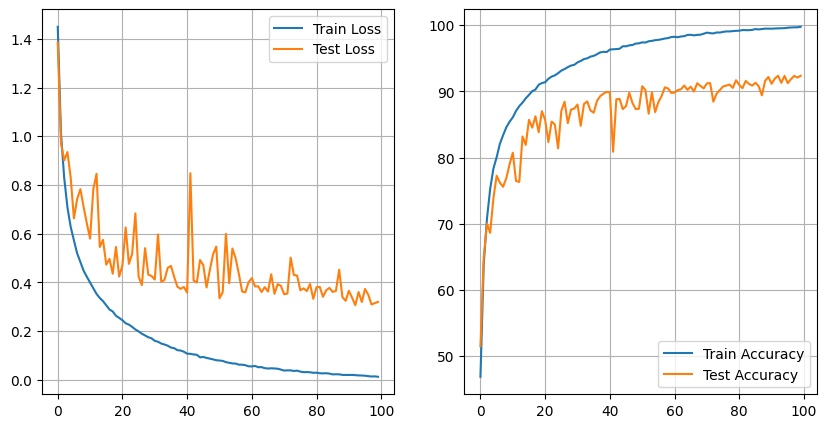

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
x_axis = range(EPOCHS)
ax0.plot(x_axis, history['loss'], label='Train Loss')
ax0.plot(x_axis, history['test_loss'], label='Test Loss')
ax1.plot(x_axis, history['accuracy'], label='Train Accuracy')
ax1.plot(x_axis, history['test_accuracy'], label='Test Accuracy')
ax0.grid(True)
ax1.grid(True)
ax0.legend()
ax1.legend()
f.savefig("./trainTestCurve.png")

## Visualize the Predictions

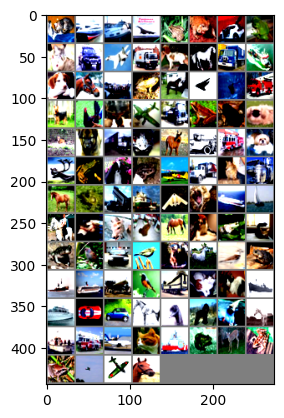

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Plot Confusion Matrix

In [ ]:
def get_predictions(model, iterator, device):
  ## Set model to evaluate mode 

  model.eval()
  
  ## Labels and probability lists 

  labels = []
  probs = []
  
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

In [ ]:
labels, probs = get_predictions(net, testloader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

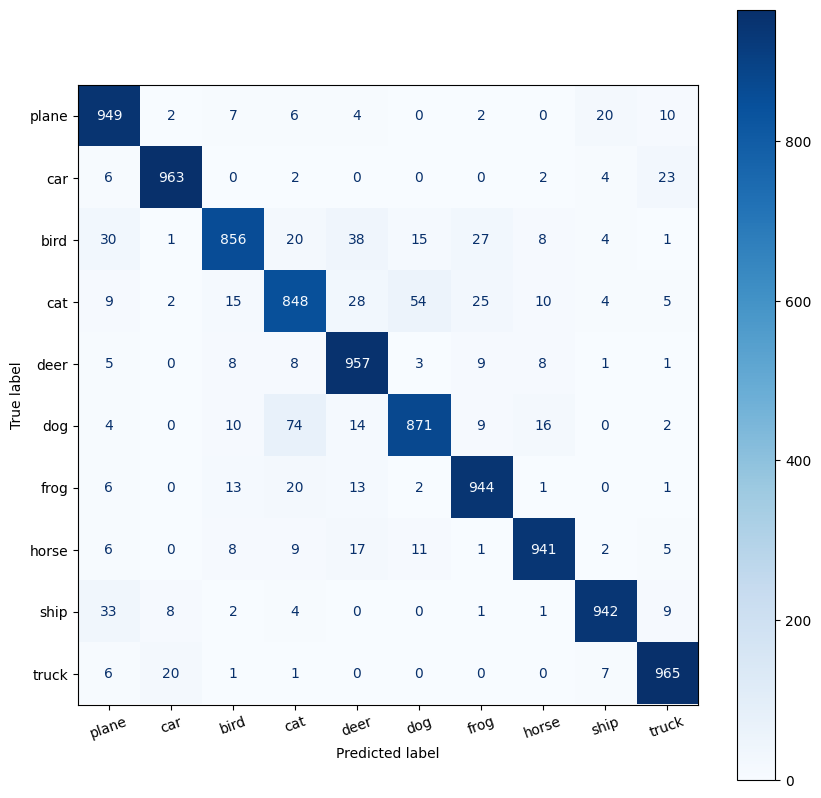

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)